In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from huggingface_hub import hf_hub_download

from PIL import Image
import evaluate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm.notebook import tqdm
import wandb


In [3]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "groundtruth")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          if root.split("/")[-1] != "images":
            files = [root.split("/")[-1] + "/" + f for f in files]
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          if root.split("/")[-1] != "groundtruth":
            files = [root.split("/")[-1] + "/" + f for f in files]
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [4]:
root_dir = '/content/drive/MyDrive/road_seg/data'
image_processor = SegformerImageProcessor(reduce_labels=False, do_resize=False)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 1120
Number of validation examples: 20


In [6]:
encoded_inputs = train_dataset[-1]

encoded_inputs["pixel_values"].shape

torch.Size([3, 400, 400])

In [7]:
encoded_inputs["labels"].shape

torch.Size([400, 400])

In [8]:
np.unique(encoded_inputs["labels"], return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119,
        120, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182

In [9]:
batch_size = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [10]:
batch = next(iter(train_dataloader))

In [11]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([4, 3, 400, 400])
labels torch.Size([4, 400, 400])


In [12]:
# load id2label mapping from a JSON on the hub
#repo_id = "huggingface/label-files"
#filename = "ade20k-id2label.json"
#id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
#id2label = {int(k): v for k, v in id2label.items()}
#label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=2,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# metric = evaluate.load("mean_iou")
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])


In [13]:
metric = evaluate.load("mean_iou")

In [14]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Set best f1 score so far
best_f1 = 0.0

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
job_type = "train_model"
config = {
    "optimizer": "adam",
    "batch_size": batch_size,
    "epochs": epochs,
}

# Initialize a W&B run
run = wandb.init(project="ml_p2", job_type=job_type, config=config)

model.train()
for epoch in range(epochs):  # loop over the dataset multiple times
  print("Epoch:", epoch+1)
  for idx, batch in enumerate(tqdm(train_dataloader)):
    # get the inputs;
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].div(255).round().long().to(device)
    # labels = torch.where(batch["labels"] == 255, 0, 1).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits

    loss.backward()
    optimizer.step()

    # evaluate
    with torch.no_grad():
      upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)

      # note that the metric expects predictions + labels as numpy arrays
      # clf_metrics.add_batch(predictions=predicted.detach().cpu().numpy().flatten(), references=labels.detach().cpu().numpy().flatten())
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # let's print loss and metrics every 100 batches
    if idx % 100 == 0:
      # currently using _compute instead of compute
      # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
      metrics = metric._compute(
              predictions=predicted.cpu(),
              references=labels.cpu(),
              num_labels=2,
              ignore_index=None,
              reduce_labels=False, # we've already reduced the labels ourselves
          )


      print("Loss:", loss.item())
      # print("Accuracy:", metrics["accuracy"])
      # print("F1 score:", metrics["f1"])
      # print("Precision:", metrics["precision"])
      # print("Recall:", metrics["recall"])
      print("Mean_iou:", metrics["mean_iou"])
      print("Pixel-wise accuracy:", metrics["overall_accuracy"])
      wandb.log({"Epoch": epoch, "Train accuracy": metrics["overall_accuracy"], "Train loss": loss.item(), "Mean IoU": metrics["mean_iou"]})
      #wandb.log({"Epoch": epoch, "Train accuracy": metrics['accuracy'], "Train loss": loss.item(), "Train F1": metrics['f1'], "Train recall": metrics['recall'], "Train precision": metrics['precision']})

  all_preds = []
  all_labels = []

  model.eval()  # Set model to evaluation mode
  validation_loss = 0.0
  with torch.no_grad():
    for val_batch in tqdm(valid_dataloader, desc="Validation"):
      # Get the inputs
      pixel_values = val_batch["pixel_values"].to(device)
      # labels = torch.where(val_batch["labels"] == 255, 0, 1).to(device)
      labels = val_batch["labels"].div(255).round().long().to(device)

      # Forward pass
      outputs = model(pixel_values=pixel_values, labels=labels)
      val_loss, logits = outputs.loss, outputs.logits
      validation_loss += val_loss.item()

      # Evaluate validation metrics
      upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)

      # clf_metrics.add_batch(predictions=predicted.detach().cpu().numpy().flatten(), references=labels.detach().cpu().numpy().flatten())
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # Collect predictions and labels for F1 score
      all_preds.append(predicted.cpu().numpy().flatten())
      all_labels.append(labels.cpu().numpy().flatten())

  # Compute overall metrics for validation
  val_metrics = metric._compute(
      predictions=predicted.cpu(),
      references=labels.cpu(),
      num_labels=2,
      ignore_index=None,
      reduce_labels=False,
  )
  avg_val_loss = validation_loss / len(valid_dataloader)


  # Compute pixel-wise F1 score for the entire validation set
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)
  pixelwise_f1_val = f1_score(all_labels, all_preds, average="binary")
  pixelwise_recall_val = recall_score(all_labels, all_preds)
  pixelwise_precision_val = precision_score(all_labels, all_preds)
  pixelwise_accuracy_val = accuracy_score(all_labels, all_preds)
  # print(f"Validation Loss: {avg_val_loss:.4f}")
  print(f"Validation Loss: {avg_val_loss:.4f} | Mean IOU: {val_metrics['mean_iou']:.4f} | Mean Accuracy: {val_metrics['mean_accuracy']:.4f}")
  print(f"Validation F1 Score: {pixelwise_f1_val:.4f}")
  print(f"Validation Recall: {pixelwise_recall_val:.4f}")
  print(f"Validation Precision: {pixelwise_precision_val:.4f}")
  print(f"Validation Accuracy: {pixelwise_accuracy_val:.4f}")

  wandb.log({"Epoch": epoch+1, "Val accuracy": pixelwise_accuracy_val, "Val loss": avg_val_loss, "Val F1": pixelwise_f1_val, "Val recall": pixelwise_recall_val, "Val precision": pixelwise_precision_val, "Mean accuracy": val_metrics['mean_accuracy'], "Mean IoU": val_metrics['mean_iou']})

  if pixelwise_f1_val > best_f1:
    best_f1 = pixelwise_f1_val
    print("Saving best model")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/road_seg/models/finetuned_segformer_{epoch+1}.pth")
    wandb.save(f"/content/drive/MyDrive/road_seg/models/finetuned_segformer_{epoch+1}.pth")

wandb.finish()

Epoch,▁▁▁█
Mean IoU,▁▇█▇
Mean accuracy,▁
Train accuracy,▁██
Train loss,█▂▁
Val F1,▁
Val accuracy,▁
Val loss,▁
Val precision,▁
Val recall,▁
Epoch,1


Epoch: 1


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.7742361426353455
Mean_iou: 0.24630216435610586
Pixel-wise accuracy: 0.395909375
Loss: 0.19973710179328918
Mean_iou: 0.8016365129498597
Pixel-wise accuracy: 0.9210359375
Loss: 0.10646997392177582
Mean_iou: 0.8934907507999588
Pixel-wise accuracy: 0.958609375


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1530 | Mean IOU: 0.8097 | Mean Accuracy: 0.8985
Validation F1 Score: 0.8483
Validation Recall: 0.8286
Validation Precision: 0.8690
Validation Accuracy: 0.9372
Saving best model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 2


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.09271000325679779
Mean_iou: 0.8844158543166445
Pixel-wise accuracy: 0.9606328125
Loss: 0.1240035891532898
Mean_iou: 0.8326414111752798
Pixel-wise accuracy: 0.9416265625
Loss: 0.0746212899684906
Mean_iou: 0.9146529459801102
Pixel-wise accuracy: 0.9686875


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1634 | Mean IOU: 0.8016 | Mean Accuracy: 0.9069
Validation F1 Score: 0.8527
Validation Recall: 0.8790
Validation Precision: 0.8279
Validation Accuracy: 0.9356
Saving best model
Epoch: 3


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.08700989931821823
Mean_iou: 0.8996834737178947
Pixel-wise accuracy: 0.960828125
Loss: 0.04854554310441017
Mean_iou: 0.9150289418269106
Pixel-wise accuracy: 0.9788421875
Loss: 0.10367761552333832
Mean_iou: 0.8765261472132256
Pixel-wise accuracy: 0.958490625


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1660 | Mean IOU: 0.8176 | Mean Accuracy: 0.8980
Validation F1 Score: 0.8564
Validation Recall: 0.8355
Validation Precision: 0.8783
Validation Accuracy: 0.9406
Saving best model
Epoch: 4


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.05628976970911026
Mean_iou: 0.9004448523348739
Pixel-wise accuracy: 0.9761828125
Loss: 0.03751421347260475
Mean_iou: 0.9512830429953407
Pixel-wise accuracy: 0.984165625
Loss: 0.04614189267158508
Mean_iou: 0.9364952645145277
Pixel-wise accuracy: 0.9802171875


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1799 | Mean IOU: 0.8319 | Mean Accuracy: 0.9045
Validation F1 Score: 0.8637
Validation Recall: 0.8335
Validation Precision: 0.8962
Validation Accuracy: 0.9443
Saving best model
Epoch: 5


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.0748760998249054
Mean_iou: 0.8734323687793597
Pixel-wise accuracy: 0.9668484375
Loss: 0.05128908157348633
Mean_iou: 0.9470104877910746
Pixel-wise accuracy: 0.9779984375
Loss: 0.04313018172979355
Mean_iou: 0.9478855323325537
Pixel-wise accuracy: 0.98159375


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.1766 | Mean IOU: 0.8465 | Mean Accuracy: 0.9189
Validation F1 Score: 0.8693
Validation Recall: 0.8612
Validation Precision: 0.8775
Validation Accuracy: 0.9451
Saving best model
Epoch: 6


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.03527846187353134
Mean_iou: 0.956604615211438
Pixel-wise accuracy: 0.9848640625
Loss: 0.038670219480991364
Mean_iou: 0.9523702661866564
Pixel-wise accuracy: 0.9839375
Loss: 0.029830176383256912
Mean_iou: 0.9621694069898921
Pixel-wise accuracy: 0.9877171875


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.2191 | Mean IOU: 0.8394 | Mean Accuracy: 0.9143
Validation F1 Score: 0.8650
Validation Recall: 0.8509
Validation Precision: 0.8796
Validation Accuracy: 0.9437
Epoch: 7


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.04517748951911926
Mean_iou: 0.9425909525300049
Pixel-wise accuracy: 0.9806671875
Loss: 0.03808277100324631
Mean_iou: 0.9529914640717199
Pixel-wise accuracy: 0.9837328125
Loss: 0.021527236327528954
Mean_iou: 0.9654504715089652
Pixel-wise accuracy: 0.990840625


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.2371 | Mean IOU: 0.8407 | Mean Accuracy: 0.9151
Validation F1 Score: 0.8678
Validation Recall: 0.8572
Validation Precision: 0.8786
Validation Accuracy: 0.9446
Epoch: 8


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.03338891640305519
Mean_iou: 0.9601044118898047
Pixel-wise accuracy: 0.986209375
Loss: 0.021901359781622887
Mean_iou: 0.9776384896192962
Pixel-wise accuracy: 0.990659375
Loss: 0.023848410695791245
Mean_iou: 0.9645250708334615
Pixel-wise accuracy: 0.9894046875


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.2564 | Mean IOU: 0.8427 | Mean Accuracy: 0.9189
Validation F1 Score: 0.8685
Validation Recall: 0.8610
Validation Precision: 0.8761
Validation Accuracy: 0.9447
Epoch: 9


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.0309979896992445
Mean_iou: 0.9693982691947485
Pixel-wise accuracy: 0.9876828125
Loss: 0.022647321224212646
Mean_iou: 0.9713783741244999
Pixel-wise accuracy: 0.990509375
Loss: 0.029446642845869064
Mean_iou: 0.9611700434036055
Pixel-wise accuracy: 0.98700625


In [108]:
torch.save(model.state_dict(), "/content/drive/MyDrive/road_seg/models/finetuned_segformer_1.pth")

In [15]:
# Load the model state dict
model_path = "/content/drive/MyDrive/road_seg/models/finetuned_segformer_5.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print(f"Model state dict loaded from {model_path}")

<ipython-input-15-60b43f9be9d8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Model state dict loaded from /content/drive/MyDrive/road_seg/models/finetuned_segformer_5.pth


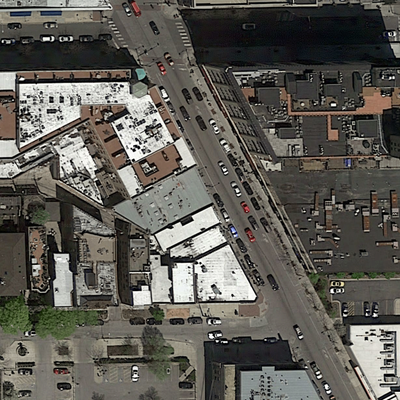

In [26]:
image = Image.open('/content/drive/MyDrive/road_seg/data/validation/images/satImage_083.png')
image

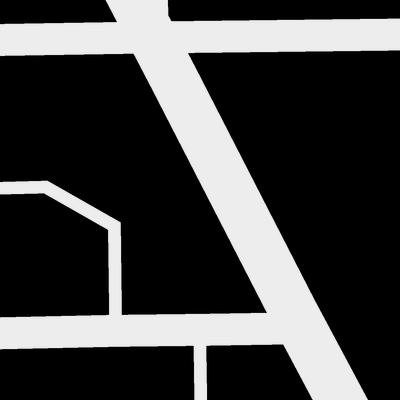

In [25]:
true_seg = Image.open('/content/drive/MyDrive/road_seg/data/validation/groundtruth/satImage_083.png')
true_seg

In [27]:
# prepare the image for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)


torch.Size([1, 3, 400, 400])


In [28]:
# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 100, 100])


In [29]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [30]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


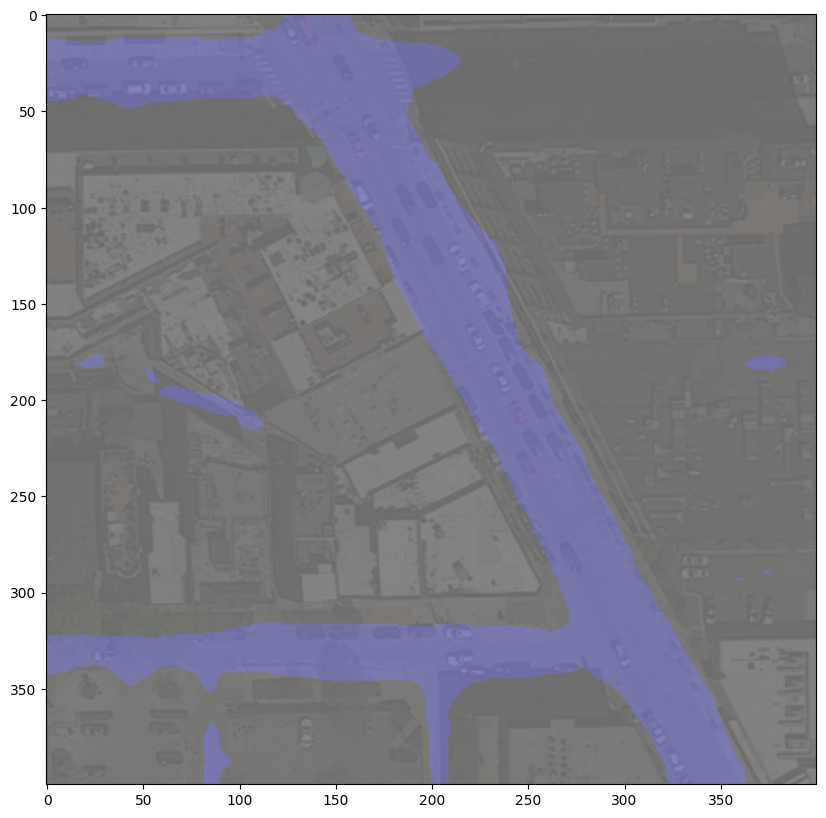

In [31]:
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.1 + color_seg * 0.9
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()  # Set model to evaluation mode
validation_loss = 0.0
all_preds = []
all_labels = []
with torch.no_grad():
  for val_batch in tqdm(valid_dataloader, desc="Validation"):
    # Get the inputs
    pixel_values = val_batch["pixel_values"].to(device)
    labels = val_batch["labels"].div(255).round().long().to(device)
    # labels = torch.where(val_batch["labels"] == 255, 0, 1).to(device)

    # Forward pass
    outputs = model(pixel_values=pixel_values, labels=labels)
    val_loss, logits = outputs.loss, outputs.logits
    validation_loss += val_loss.item()

    # Evaluate validation metrics
    upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)


    metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # Collect predictions and labels for F1 score
    all_preds.append(predicted.cpu().numpy().flatten())
    all_labels.append(labels.cpu().numpy().flatten())

# Compute overall metrics for validation
val_metrics = metric._compute(
    predictions=predicted.cpu(),
    references=labels.cpu(),
    num_labels=2,
    ignore_index=None,
    reduce_labels=False,
)
avg_val_loss = validation_loss / len(valid_dataloader)

# Compute pixel-wise F1 score for the entire validation set
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
pixelwise_f1_val = f1_score(all_labels, all_preds, average="binary")
pixelwise_recall_val = recall_score(all_labels, all_preds)
pixelwise_precision_val = precision_score(all_labels, all_preds)

print(f"Validation Loss: {avg_val_loss:.4f} | Mean IOU: {val_metrics['mean_iou']:.4f} | Mean Accuracy: {val_metrics['mean_accuracy']:.4f}")
print(f"Pixel-wise F1 Score: {pixelwise_f1_val:.4f}")
print(f"Pixel-wise Recall: {pixelwise_recall_val:.4f}")
print(f"Pixel-wise Precision: {pixelwise_precision_val:.4f}")


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Validation Loss: 0.1766 | Mean IOU: 0.8465 | Mean Accuracy: 0.9189
Pixel-wise F1 Score: 0.8693
Pixel-wise Recall: 0.8612
Pixel-wise Precision: 0.8775


In [39]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images = sorted(os.listdir("/content/drive/MyDrive/road_seg/data/test"))

for im in images:
  print(im)
  # Open the image
  image = Image.open(f"/content/drive/MyDrive/road_seg/data/test/{im}/{im}.png")

  # Prepare the image for the model
  pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

  # forward pass
  with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

  # logits are of shape (batch_size, num_labels, height/4, width/4)
  logits = outputs.logits.cpu()

  predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
  predicted_segmentation_map = predicted_segmentation_map.mul(255)
  predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
  color_seg = np.zeros((predicted_segmentation_map.shape[0],
                        predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

  palette = np.array(ade_palette())
  for label, color in enumerate(palette):
      color_seg[predicted_segmentation_map == label, :] = color
  # Convert to BGR
  color_seg = color_seg[..., ::-1]
  color_seg = color_seg.astype(np.uint8)

  predicted_segmentation_map = predicted_segmentation_map.astype(np.uint8)

  segm_im = Image.fromarray(predicted_segmentation_map)
  segm_im.save(f"/content/drive/MyDrive/road_seg/data/test/{im}/{im}_pred_segformer_ft_5.png")


test_1
test_10
test_11
test_12
test_13
test_14
test_15
test_16
test_17
test_18
test_19
test_2
test_20
test_21
test_22
test_23
test_24
test_25
test_26
test_27
test_28
test_29
test_3
test_30
test_31
test_32
test_33
test_34
test_35
test_36
test_37
test_38
test_39
test_4
test_40
test_41
test_42
test_43
test_44
test_45
test_46
test_47
test_48
test_49
test_5
test_50
test_6
test_7
test_8
test_9


In [33]:
from mask_to_submission import *

In [83]:
submission_filename = 'submission_segformer_ft_5.csv'
image_filenames = []
for i in range(1, 51):
  image_filename = f"/content/drive/MyDrive/road_seg/data/test/test_{i}/test_{i}_pred_segformer_ft_5.png"
  # print(image_filename)
  image_filenames.append(image_filename)
# masks_to_submission(submission_filename, *image_filenames)

In [84]:
image_filenames

['/content/drive/MyDrive/road_seg/data/test/test_1/test_1_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_2/test_2_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_3/test_3_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_4/test_4_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_5/test_5_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_6/test_6_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_7/test_7_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_8/test_8_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_9/test_9_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_10/test_10_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_11/test_11_pred_segformer_ft_5.png',
 '/content/drive/MyDrive/road_seg/data/test/test_12/test_12_pred_segform

In [85]:
masks_to_submission(submission_filename, *image_filenames)